### Out of core groupby comparison

A few libraries to compute out-of-core pandas-style groupbys exist. 

*  BQuery
*  Blaze
*  Dask

This notebook was modified from a notebook on the bquery repository.  We've made the following changes:

1.  Increased the dataset size.  This precludes the pandas comparison but helps blaze, whose overhead resulted in poor performance on very small chunked datasets.  Argumably this new size and chunksize are more representative of actual problems on which these technologies would be used.
2.  Added a Blaze multiprocessing solution
3.  Added comparison with dask.dataframe (which does surprisingly well)
4.  End with a profile run of the dask.dataframe solution.
5.  Removed the complex query section at the end.

The following introduction, the setup, and most of the experiment lines come from the [original notebook](https://github.com/visualfabriq/bquery/blob/master/bquery/benchmarks/bench_groupby.ipynb)

Disclaimer: I am biased towards Blaze and Dask and so may have inadvertently selected options that flatter those projects.  

# Bquery - groupby on-disk

In this notebook we will compare the performance several groupby solutions over out-of-core (disk-based) bcolz files against Python's golden standard: the fast, in-memory Pandas framework.

Our goal is to show how with bcolz you can approach (and in some cases even exceed) the Pandas in-memory performance while working with solutions that only have the intermediate and/or end result in-memory.

We will have two test cases: 
1) a query with a single groupby column and a single aggregated (sum) column
2) a query with five groupby columns and three aggregated (sum) columns

This is a simple example with 1 million rows, but you can experiment with other sizes to see how they affect the outcome.

This performance comparison was run on a 16gb ram, 8 core, SSD-based DigitalOcean server on Ubuntu 14.04. System caching might influence the results, but in our experience this very much resembles our real-life experience. We encourage anyone to have their own test and share them with us.

For the impatient, you can scroll to the end to see a graphical presentation of the performance results.

The bquery framework provides methods to perform query and aggregation operations on bcolz containers, as well as accelerate these operations by pre-processing possible groupby columns.

Bcolz is a light weight package that provides columnar, chunked data containers that can be compressed either in-memory and on-disk. that are compressed by default not only for reducing memory/disk storage, but also to improve I/O speed. It excels at storing and sequentially accessing large, numerical data sets.  

The code you'll find below was inspired on the following nicely written notebooks:  
Blaze - http://nbviewer.ipython.org/url/blaze.pydata.org/notebooks/timings-bcolz.ipynb  
Bcolz - http://nbviewer.ipython.org/github/Blosc/movielens-bench/blob/master/querying-ep14.ipynb

In [1]:
%matplotlib inline

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import itertools as itt
import time
import shutil
import os
import contextlib
import pandas as pd
import blaze as blz
import bquery
import cytoolz
from cytoolz.curried import pluck as cytoolz_pluck
from collections import OrderedDict
import copy
from prettyprint import pp

Couldn't import dot_parser, loading of dot files will not be possible.


In [3]:
elapsed_times = OrderedDict()

@contextlib.contextmanager
def ctime(message=None):
    "Counts the time spent in some context"
    assert message is not None
    global elapsed_times
    t_elapsed = 0.0
    print('\n')
    t = time.time()
    yield
    if message:
        print message + ":  ", 
    t_elapsed = time.time() - t
    print round(t_elapsed, 4), "sec"
    elapsed_times[message] = t_elapsed


ga = itt.cycle(['ES', 'NL'])
gb = itt.cycle(['b1', 'b2', 'b3', 'b4', 'b5'])
gx = itt.cycle([1, 2])
gy = itt.cycle([-1, -2])
rootdir = 'bench-data.bcolz'
if os.path.exists(rootdir):
    shutil.rmtree(rootdir)

n_rows = 10000000

# -- data
z = np.fromiter(((a, b, x, y) for a, b, x, y in itt.izip(ga, gb, gx, gy)),
                dtype='S2,S2,i8,i8', count=n_rows)

In [4]:
ct = bquery.ctable(z, rootdir=rootdir, chunklen=1000000)
ct.flush()

In [5]:
ct['f0'].chunklen

1000000

### blaze

In [6]:
print('Simple Test Case')
blaze_data = blz.Data(ct.rootdir)
expr = blz.by(blaze_data.f0, sum_f2=blaze_data.f2.sum())
with ctime(message='blaze (pandas + bcolz)'):
    result = blz.compute(expr)
# print result

Simple Test Case


blaze (pandas + bcolz):   2.1971 sec


In [7]:
import multiprocessing as mp
p = mp.Pool()

with ctime(message='blaze + multiprocessing'):
    result = blz.compute(expr, map=p.map)
# print result



blaze + multiprocessing:   1.438 sec


In [8]:
result

,f0,sum_f2
0,ES,5000000
1,NL,10000000


In [9]:
import dask.dataframe as dd
df = dd.from_bcolz(ct)

In [10]:
with ctime(message='dask single threaded'):
    df.groupby('f0').f2.sum().compute()



dask single threaded:   0.6374 sec


In [11]:
# I use the pandas branch jreback/gil at b6eea4b5f8896c107310c3a10c1cb65f108b568a

from dask.threaded import get
with ctime(message='dask with threading'):
    df.groupby('f0').f2.sum().compute(get=get)



dask with threading:   0.5583 sec


### bquery without caching

In [12]:
print('Simple Test Case')
with ctime(message='bquery + bcolz'):
    result = ct.groupby(['f0'], ['f2'])
# print(result)

Simple Test Case


bquery + bcolz:   2.2219 sec


### bquery with caching

In [13]:
print('Simple Test Case')
with ctime(message='bquery, create factorization cache'):
    ct.cache_factor(['f0'], refresh=True)

with ctime(message='bquery + bcolz (fact. cached)'):
    result = ct.groupby(['f0'], ['f2'])
# print(result)

Simple Test Case


bquery, create factorization cache:   0.8123 sec


bquery + bcolz (fact. cached):   1.4794 sec


### Running Times Summary

In [14]:
print('Simple Test Case Running Time')
elapsed_times_bak = OrderedDict({ k: v for (k,v) in sorted(elapsed_times.iteritems())})
pp(elapsed_times_bak)

Simple Test Case Running Time
{
    "blaze (pandas + bcolz)": 2.197126865386963, 
    "blaze + multiprocessing": 1.4379968643188477, 
    "bquery + bcolz": 2.2219109535217285, 
    "bquery + bcolz (fact. cached)": 1.4794340133666992, 
    "bquery, create factorization cache": 0.8123009204864502, 
    "dask single threaded": 0.6374270915985107, 
    "dask with threading": 0.5583410263061523
}


In [15]:
print('Simple Test Case Running Time (s)')
elapsed_times_bak = OrderedDict({ k: v for (k,v) in sorted(elapsed_times.iteritems())})
pp(elapsed_times_bak)
elapsed_times = elapsed_times_bak
elapsed_times_norm = OrderedDict({ k: v for (k,v) in sorted(elapsed_times.iteritems())})
print '\Running time'
pp(elapsed_times_norm)

Simple Test Case Running Time (s)
{
    "blaze (pandas + bcolz)": 2.197126865386963, 
    "blaze + multiprocessing": 1.4379968643188477, 
    "bquery + bcolz": 2.2219109535217285, 
    "bquery + bcolz (fact. cached)": 1.4794340133666992, 
    "bquery, create factorization cache": 0.8123009204864502, 
    "dask single threaded": 0.6374270915985107, 
    "dask with threading": 0.5583410263061523
}
\Running time
{
    "blaze (pandas + bcolz)": 2.197126865386963, 
    "blaze + multiprocessing": 1.4379968643188477, 
    "bquery + bcolz": 2.2219109535217285, 
    "bquery + bcolz (fact. cached)": 1.4794340133666992, 
    "bquery, create factorization cache": 0.8123009204864502, 
    "dask single threaded": 0.6374270915985107, 
    "dask with threading": 0.5583410263061523
}


### Graphic Summary

['dask with threading', 'bquery + bcolz (fact. cached)', 'blaze + multiprocessing', 'dask single threaded', 'bquery + bcolz', 'blaze (pandas + bcolz)']


<Container object of 6 artists>

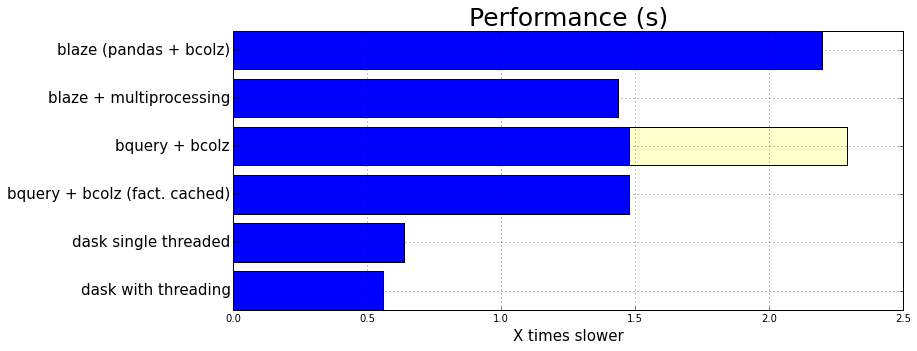

In [16]:
if 'bquery, create factorization cache' in elapsed_times_norm:
    base_bquery = elapsed_times_norm.pop('bquery, create factorization cache')
labels = []
val = []
for k,v in sorted(elapsed_times_norm.iteritems(), reverse=True):
    labels.append(k)
    val.append(v)

pos = np.arange(len(elapsed_times_norm))+.5    # the bar centers on the y axis

print elapsed_times_norm.keys()
plt.figure(1, figsize=[12,5])
plt.grid(True)
plt.barh(pos,val, align='center')
plt.yticks(pos, labels, fontsize=15)
plt.xlabel('X times slower', fontsize=15)
plt.title('Performance (s)', fontsize=25)

plt.barh(pos,[0, 0, 0, base_bquery, 0, 0], 
         left=[0, 0, 0, elapsed_times_norm['bquery + bcolz (fact. cached)'], 0, 0],
         align='center', color = '#FFFFCC')


The Light yellow shows the one-time factorization caching (which after the first run can be left out of future queries).  
NB: when data changes, this caching has to be refreshed but it is very useful in most reporting & analytics cases.

### Profile Dask Solution

Why didn't threading help much?

In [17]:
%prun df.groupby('f0').f2.sum().compute()

```
         25876 function calls (25170 primitive calls) in 0.651 seconds

   Ordered by: internal time

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
       20    0.294    0.015    0.294    0.015 {method 'searchsorted' of 'numpy.ndarray' objects}
       10    0.125    0.013    0.552    0.055 io.py:305(dataframe_from_ctable)
      181    0.044    0.000    0.044    0.000 {method 'reduce' of 'numpy.ufunc' objects}
       11    0.037    0.003    0.037    0.003 {pandas.algos.group_add_float64}
       11    0.034    0.003    0.034    0.003 internals.py:3717(_stack_arrays)
       11    0.021    0.002    0.021    0.002 {pandas.algos.ensure_float64}
       65    0.019    0.000    0.019    0.000 {pandas.algos.ensure_int8}
       57    0.015    0.000    0.015    0.000 {pandas.algos.ensure_int64}
      106    0.015    0.000    0.015    0.000 {numpy.core.multiarray.arange}
     4810    0.002    0.000    0.003    0.000 {isinstance}
       51    0.002    0.000    0.006    0.000 index.py:109(__new__)
2033/1524    0.001    0.000    0.002    0.000 {len}
  394/393    0.001    0.000    0.001    0.000 {numpy.core.multiarray.array}
       64    0.001    0.000    0.003    0.000 core.py:177(get_dependencies)
       76    0.001    0.000    0.001    0.000 {pandas.lib.infer_dtype}
       11    0.001    0.000    0.039    0.004 internals.py:3559(form_blocks)
```